$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 2: Variational Autoencoder
<a id=part2></a>

In this part we will learn to generate new data using a special type of autoencoder model which allows us to 
sample from its latent space. We'll implement and train a VAE and use it to generate new images.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part2_1></a>

Let's begin by downloading a dataset of images that we want to learn to generate. 
We'll use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset which contains many labeled faces of famous individuals.

We're going to train our generative model to generate a specific face, not just any face.
Since the person with the most images in this dataset is former president George W. Bush, we'll set out to train a Bush Generator :)

However, if you feel adventurous and/or prefer to generate something else, feel free to edit the `PART2_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [3]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART2_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'https://github.com/AviaAvraham1/TempDatasets/raw/refs/heads/main/George_W_Bush2.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

Saved to /home/eran.b/.pytorch-datasets/George_W_Bush2.zip.
Extracting /home/eran.b/.pytorch-datasets/George_W_Bush2.zip...


Extracted 532 to /home/eran.b/.pytorch-datasets/George_W_Bush/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [4]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


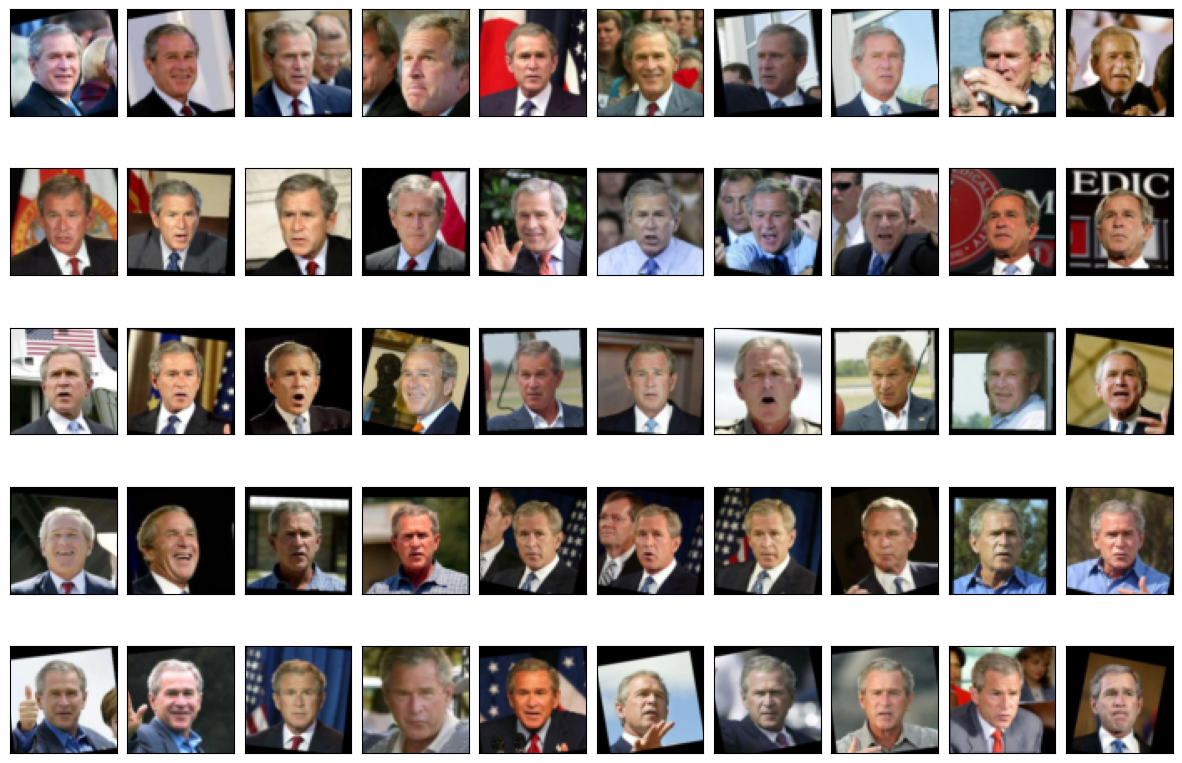

In [5]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## The Variational Autoencoder
<a id=part2_2></a>

An autoencoder is a model which learns a representation of data in an **unsupervised** fashion (i.e without any labels).
Recall it's general form from the lecture:

<img src="imgs/autoencoder.jpg"/>

An autoencoder maps an instance $\bb{x}$ to a **latent-space** representation $\bb{z}$.
It has an encoder part, $\Phi_{\bb{\alpha}}(\bb{x})$ (a model with parameters $\bb{\alpha}$)
and a decoder part, $\Psi_{\bb{\beta}}(\bb{z})$ (a model with parameters $\bb{\beta}$).

While autoencoders can learn useful representations,
generally it's hard to use them as generative models because there's no distribution we can sample from in the latent space. In other words, we have no way to choose a point $\bb{z}$ in the latent space
such that $\Psi(\bb{z})$ will end up on the data manifold in the instance space.

<img src="imgs/ae_sampling.jpg"/>


The variational autoencoder (VAE), first proposed by [Kingma and Welling](https://arxiv.org/pdf/1312.6114.pdf), addresses this issue by taking a probabilistic perspective. 
Briefly, a VAE model can be described as follows.

We define, in Baysean terminology,
- The **prior** distribution $p(\bb{Z})$ on points in the latent space.
- The **posterior** distribution of points in the latent spaces given a specific instance: $p(\bb{Z}|\bb{X})$.
- The **likelihood** distribution of a sample $\bb{X}$ given a latent-space representation: $p(\bb{X}|\bb{Z})$.
- The **evidence** distribution $p(\bb{X})$ which is the distribution of the instance space due to the generative process.

To create our variational **decoder** we'll further specify:

- A parametric likelihood distribution, $p _{\bb{\beta}}(\bb{X} | \bb{Z}=\bb{z}) = \mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$. The interpretation is that given a latent $\bb{z}$, we map it to a point normally distributed around the point calculated by our decoder neural network. Note that here $\sigma^2$ is a hyperparameter while $\vec{\beta}$ represents the network parameters.
- A fixed latent-space prior distribution of $p(\bb{Z}) = \mathcal{N}(\bb{0},\bb{I})$.

This setting allows us to generate a new instance $\bb{x}$ by sampling $\bb{z}$ from the multivariate normal
distribution, obtaining the instance-space mean $\Psi _{\bb{\beta}}(\bb{z})$ using our decoder network,
and then sampling $\bb{x}$ from $\mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$.

Our variational **encoder** will approximate the posterior with a parametric distribution 
$q _{\bb{\alpha}}(\bb{Z} | \bb{x}) =
\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$.
The interpretation is that our encoder model, $\Phi_{\vec{\alpha}}(\bb{x})$, calculates
the mean and variance of the posterior distribution, and samples $\bb{z}$ based on them.
An important nuance here is that our network can't contain any stochastic elements that
depend on the model parameters, otherwise we won't be able to back-propagate to those parameters.
So sampling $\bb{z}$ from $\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$ is not an option.
The solution is to use what's known as the **reparametrization trick**: sample from an isotropic Gaussian, 
i.e. $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ (which doesn't depend on trainable parameters), and calculate the latent representation as
$\bb{z} = \bb{\mu} _{\bb{\alpha}}(\bb{x}) + \bb{u}\odot\bb{\sigma}_{\bb{\alpha}}(\bb{x})$.

To train a VAE model, we maximize the evidence distribution, $p(\bb{X})$ (see question below). 
The **VAE loss** can therefore be stated as minimizing $\mathcal{L} = -\mathbb{E}_{\bb{x}} \log p(\bb{X})$.
Although this expectation is intractable,
we can obtain a lower-bound for $p(\bb{X})$ (the evidence lower bound, "ELBO", shown in the lecture):

$$
\log p(\bb{X}) \ge \mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ \log  p _{\bb{\beta}}(\bb{X} | \bb{z}) \right]
-  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{X})\,\left\|\, p(\bb{Z} )\right.\right)
$$

where
$
\mathcal{D} _{\mathrm{KL}}(q\left\|\right.p) =
\mathbb{E}_{\bb{z}\sim q}\left[ \log \frac{q(\bb{Z})}{p(\bb{Z})} \right]
$
is the Kullback-Liebler divergence, which can be interpreted as the information gained by using the posterior $q(\bb{Z|X})$ instead of the prior distribution $p(\bb{Z})$.

Using the ELBO, the VAE loss becomes,
$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ -\log  p _{\bb{\beta}}(\bb{x} | \bb{z}) \right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$

By remembering that the likelihood is a Gaussian distribution with a diagonal covariance and by applying the reparametrization trick, we can write the above as

$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }
\left[ 
\frac{1}{2\sigma^2}\left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  + \bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2
\right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$



### Model Implementation
<a id=part2_3></a>

Obviously our model will have two parts, an encoder and a decoder.
Since we're working with images, we'll implement both as deep **convolutional** networks, where the decoder is a "mirror image" of the encoder implemented with adjoint (AKA transposed) convolutions.
Between the encoder CNN and the decoder CNN we'll implement the sampling from
the parametric posterior approximator $q_{\bb{\alpha}}(\bb{Z}|\bb{x})$
to make it a VAE model and not just a regular autoencoder (of course, this is not yet enough to create a VAE,
since we also need a special loss function which we'll get to later).

First let's implement just the CNN part of the Encoder network
(this is not the full $\Phi_{\vec{\alpha}}(\bb{x})$ yet).
As usual, it should take an input image and map to a activation volume of a specified depth.
We'll consider this volume as the features we extract from the input image.
Later we'll use these to create the latent space representation of the input.

**TODO**: Implement the `EncoderCNN` class in the `hw3/autoencoder.py` module.
Implement any CNN architecture you like. If you need "architecture inspiration" you can see e.g. [this](https://arxiv.org/pdf/1512.09300.pdf) or [this](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [7]:
import hw3.autoencoder as autoencoder

in_channels = 3
out_channels = 1024
encoder_cnn = autoencoder.EncoderCNN(in_channels, out_channels).to(device)
print(encoder_cnn)

h = encoder_cnn(x0)
print(h.shape)

test.assertEqual(h.dim(), 4)
test.assertSequenceEqual(h.shape[0:2], (1, out_channels))

EncoderCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
)


torch.Size([1, 1024, 8, 8])


Now let's implement the CNN part of the Decoder.
Again this is not yet the full $\Psi _{\bb{\beta}}(\bb{z})$. It should take an activation volume produced
by your `EncoderCNN` and output an image of the same dimensions as the Encoder's input was.
This can be a CNN which is like a "mirror image" of the the Encoder. For example, replace convolutions with transposed convolutions, downsampling with up-sampling etc.
Consult the documentation of [ConvTranspose2D](https://pytorch.org/docs/0.4.1/nn.html#convtranspose2d)
to figure out how to reverse your convolutional layers in terms of input and output dimensions. Note that the decoder doesn't have to be exactly the opposite of the encoder and you can experiment with using a different architecture.

**TODO**: Implement the `DecoderCNN` class in the `hw3/autoencoder.py` module.

DecoderCNN(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


torch.Size([1, 3, 64, 64])


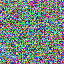

In [8]:
decoder_cnn = autoencoder.DecoderCNN(in_channels=out_channels, out_channels=in_channels).to(device)
print(decoder_cnn)
x0r = decoder_cnn(h)
print(x0r.shape)

test.assertEqual(x0.shape, x0r.shape)

# Should look like colored noise
T.functional.to_pil_image(x0r[0].cpu().detach())

Let's now implement the full VAE Encoder, $\Phi_{\vec{\alpha}}(\vec{x})$.
It will work as follows:
1. Produce a feature vector $\vec{h}$ from the input image $\vec{x}$.
2. Use two affine transforms to convert the features into the mean and log-variance of the posterior, i.e.
    $$
    \begin{align}
        \bb{\mu} _{\bb{\alpha}}(\bb{x}) &= \vec{h}\mattr{W}_{\mathrm{h\mu}} + \vec{b}_{\mathrm{h\mu}} \\
        \log\left(\bb{\sigma}^2_{\bb{\alpha}}(\bb{x})\right) &= \vec{h}\mattr{W}_{\mathrm{h\sigma^2}} + \vec{b}_{\mathrm{h\sigma^2}}
    \end{align}
    $$
3. Use the **reparametrization trick** to create the latent representation $\vec{z}$.

Notice that we model the **log** of the variance, not the actual variance.
The above formulation is proposed in appendix C of the [VAE paper](https://arxiv.org/pdf/1312.6114.pdf).

**TODO**: Implement the `encode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`.

In [9]:
z_dim = 2
vae = autoencoder.VAE(encoder_cnn, decoder_cnn, x0[0].size(), z_dim).to(device)
print(vae)

z, mu, log_sigma2 = vae.encode(x0)

test.assertSequenceEqual(z.shape, (1, z_dim))
test.assertTrue(z.shape == mu.shape == log_sigma2.shape)

print(f'mu(x0)={list(*mu.detach().cpu().numpy())}, sigma2(x0)={list(*torch.exp(log_sigma2).detach().cpu().numpy())}')

VAE(
  (features_encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (features_decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ConvTranspose2d(1024, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inp

mu(x0)=[0.8224494, -0.51938593], sigma2(x0)=[0.86267585, 1.9702746]


Let's sample some 2d latent representations for an input image `x0` and visualize them.

sampled mu tensor([ 0.8101, -0.4607])
sampled sigma2 tensor([0.9138, 1.8869])


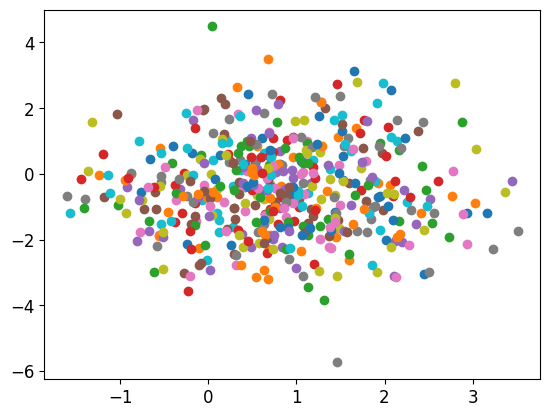

In [10]:
# Sample from q(Z|x)
N = 500
Z = torch.zeros(N, z_dim)
_, ax = plt.subplots()
with torch.no_grad():
    for i in range(N):
        Z[i], _, _ = vae.encode(x0)
        ax.scatter(*Z[i].cpu().numpy())

# Should be close to the mu/sigma in the previous block above
print('sampled mu', torch.mean(Z, dim=0))
print('sampled sigma2', torch.var(Z, dim=0))

Let's now implement the full VAE Decoder, $\Psi _{\bb{\beta}}(\bb{z})$.
It will work as follows:
1. Produce a feature vector $\tilde{\vec{h}}$ from the latent vector $\vec{z}$ using an affine transform.
2. Reconstruct an image $\tilde{\vec{x}}$ from $\tilde{\vec{h}}$ using the decoder CNN.

**TODO**: Implement the `decode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`. You may need to also re-run the block above after you implement this.

In [11]:
x0r = vae.decode(z)

test.assertSequenceEqual(x0r.shape, x0.shape)

Our model's `forward()` function will simply return `decode(encode(x))` as well as the calculated mean and log-variance of the posterior.

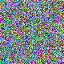

In [12]:
x0r, mu, log_sigma2 = vae(x0)

test.assertSequenceEqual(x0r.shape, x0.shape)
test.assertSequenceEqual(mu.shape, (1, z_dim))
test.assertSequenceEqual(log_sigma2.shape, (1, z_dim))
T.functional.to_pil_image(x0r[0].detach().cpu())

### Loss Implementation
<a id=part2_4></a>

In practice, since we're using SGD, we'll drop the expectation over $\bb{X}$ and instead sample an instance from the training set and compute a point-wise loss. Similarly, we'll drop the expectation over $\bb{Z}$ by sampling from $q_{\vec{\alpha}}(\bb{Z}|\bb{x})$.
Additionally, because the KL divergence is between two Gaussian distributions, there is a closed-form expression for it. These points bring us to the following point-wise loss:

$$
\ell(\vec{\alpha},\vec{\beta};\bb{x}) =
\frac{1}{\sigma^2 d_x} \left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  +
\bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2 +
\mathrm{tr}\,\bb{\Sigma} _{\bb{\alpha}}(\bb{x}) +  \|\bb{\mu} _{\bb{\alpha}}(\bb{x})\|^2 _2 - d_z - \log\det \bb{\Sigma} _{\bb{\alpha}}(\bb{x}),
$$

where $d_z$ is the dimension of the latent space, $d_x$ is the dimension of the input and $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$.
This pointwise loss is the quantity that we'll compute and minimize with gradient descent.
The first term corresponds to the data-reconstruction loss, while the second term corresponds to the KL-divergence loss.
Note that the scaling by $d_x$ is not derived from the original loss formula and was added directly to the pointwise loss just to normalize the data term.

**TODO**: Implement the `vae_loss()` function in the `hw3/autoencoder.py` module.

In [13]:
from hw3.autoencoder import vae_loss
torch.manual_seed(42)

def test_vae_loss():
    # Test data
    N, C, H, W = 10, 3, 64, 64 
    z_dim = 32
    x  = torch.randn(N, C, H, W)*2 - 1
    xr = torch.randn(N, C, H, W)*2 - 1
    z_mu = torch.randn(N, z_dim)
    z_log_sigma2 = torch.randn(N, z_dim)
    x_sigma2 = 0.9
    
    loss, _, _ = vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)
    
    test.assertAlmostEqual(loss.item(), 58.3234367, delta=1e-3)
    return loss

test_vae_loss()

tensor(58.3234)

### Sampling
<a id=part2_5></a>

The main advantage of a VAE is that it can by used as a generative model by sampling the latent space, since
we optimize for a isotropic Gaussian prior $p(\bb{Z})$ in the loss function. Let's now implement this so that we can visualize how our model is doing when we train.

**TODO**: Implement the `sample()` method in the `VAE` class within the `hw3/autoencoder.py` module.

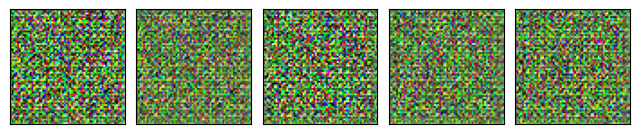

In [14]:
samples = vae.sample(5)
_ = plot.tensors_as_images(samples)

### Training
<a id=part2_6></a>

Time to train!

**TODO**:
1. Implement the `VAETrainer` class in the `hw3/training.py` module. Make sure to implement the `checkpoints` feature of the `Trainer` class if you haven't done so already in Part 1.
2. Tweak the hyperparameters in the `part2_vae_hyperparams()` function within the `hw3/answers.py` module.

In [15]:
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from hw3.training import VAETrainer
from hw3.answers import part2_vae_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part2_vae_hyperparams()
batch_size = hp['batch_size']
h_dim = hp['h_dim']
z_dim = hp['z_dim']
x_sigma2 = hp['x_sigma2']
learn_rate = hp['learn_rate']
betas = hp['betas']

# Data
split_lengths = [int(len(ds_gwb)*0.9), int(len(ds_gwb)*0.1)]
ds_train, ds_test = random_split(ds_gwb, split_lengths)
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test  = DataLoader(ds_test,  batch_size, shuffle=True)
im_size = ds_train[0][0].shape

# Model
encoder = autoencoder.EncoderCNN(in_channels=im_size[0], out_channels=h_dim)
decoder = autoencoder.DecoderCNN(in_channels=h_dim, out_channels=im_size[0])
vae = autoencoder.VAE(encoder, decoder, im_size, z_dim)
vae_dp = DataParallel(vae).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=learn_rate, betas=betas)

# Loss
def loss_fn(x, xr, z_mu, z_log_sigma2):
    return autoencoder.vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)

# Trainer
trainer = VAETrainer(vae_dp, loss_fn, optimizer, device)
checkpoint_file = 'checkpoints/vae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show model and hypers
print(vae)
print(hp)

VAE(
  (features_encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (features_decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplac

**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

The images you get should be colorful, with different backgrounds and poses.

--- EPOCH 1/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (33.956):   0%|          | 0/15 [00:01<?, ?it/s]

train_batch (33.956):   7%|▋         | 1/15 [00:01<00:14,  1.07s/it]

train_batch (46.432):   7%|▋         | 1/15 [00:01<00:14,  1.07s/it]

train_batch (22.703):  13%|█▎        | 2/15 [00:01<00:13,  1.07s/it]

train_batch (22.703):  20%|██        | 3/15 [00:01<00:04,  2.99it/s]

train_batch (23.977):  20%|██        | 3/15 [00:01<00:04,  2.99it/s]

train_batch (18.520):  27%|██▋       | 4/15 [00:01<00:03,  2.99it/s]

train_batch (18.520):  33%|███▎      | 5/15 [00:01<00:02,  4.98it/s]

train_batch (17.478):  33%|███▎      | 5/15 [00:01<00:02,  4.98it/s]

train_batch (14.959):  40%|████      | 6/15 [00:01<00:01,  4.98it/s]

train_batch (14.959):  47%|████▋     | 7/15 [00:01<00:01,  6.64it/s]

train_batch (14.143):  47%|████▋     | 7/15 [00:01<00:01,  6.64it/s]

train_batch (13.568):  53%|█████▎    | 8/15 [00:01<00:01,  6.64it/s]

train_batch (13.568):  60%|██████    | 9/15 [00:01<00:00,  8.16it/s]

train_batch (12.517):  60%|██████    | 9/15 [00:01<00:00,  8.16it/s]

train_batch (12.525):  67%|██████▋   | 10/15 [00:01<00:00,  8.16it/s]

train_batch (12.525):  73%|███████▎  | 11/15 [00:01<00:00,  9.47it/s]

train_batch (10.830):  73%|███████▎  | 11/15 [00:01<00:00,  9.47it/s]

train_batch (11.584):  80%|████████  | 12/15 [00:01<00:00,  9.47it/s]

train_batch (11.584):  87%|████████▋ | 13/15 [00:01<00:00, 10.56it/s]

train_batch (10.776):  87%|████████▋ | 13/15 [00:02<00:00, 10.56it/s]

train_batch (10.133):  93%|█████████▎| 14/15 [00:02<00:00, 10.56it/s]

train_batch (10.133): 100%|██████████| 15/15 [00:02<00:00, 11.37it/s]

train_batch (Avg. Loss 18.273, Accuracy 5.5): 100%|██████████| 15/15 [00:02<00:00, 11.37it/s]

train_batch (Avg. Loss 18.273, Accuracy 5.5): 100%|██████████| 15/15 [00:02<00:00,  7.03it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (2.197):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (2.258):  50%|█████     | 1/2 [00:00<00:00,  6.64it/s]

test_batch (2.258): 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]

test_batch (Avg. Loss 2.227, Accuracy 10.2): 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]

test_batch (Avg. Loss 2.227, Accuracy 10.2): 100%|██████████| 2/2 [00:00<00:00, 13.06it/s]

*** Saved checkpoint checkpoints/vae.pt at epoch 1

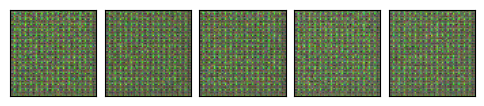

*** Saved checkpoint checkpoints/vae.pt at epoch 5


*** Saved checkpoint checkpoints/vae.pt at epoch 6


*** Saved checkpoint checkpoints/vae.pt at epoch 7


*** Saved checkpoint checkpoints/vae.pt at epoch 8


*** Saved checkpoint checkpoints/vae.pt at epoch 9


*** Saved checkpoint checkpoints/vae.pt at epoch 10
--- EPOCH 11/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (2.693):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (2.979):   7%|▋         | 1/15 [00:00<00:02,  6.20it/s]

train_batch (2.979):  13%|█▎        | 2/15 [00:00<00:01, 12.37it/s]

train_batch (2.880):  13%|█▎        | 2/15 [00:00<00:01, 12.37it/s]

train_batch (2.318):  20%|██        | 3/15 [00:00<00:00, 12.37it/s]

train_batch (2.318):  27%|██▋       | 4/15 [00:00<00:00, 13.03it/s]

train_batch (2.065):  27%|██▋       | 4/15 [00:00<00:00, 13.03it/s]

train_batch (2.057):  33%|███▎      | 5/15 [00:00<00:00, 13.03it/s]

train_batch (2.057):  40%|████      | 6/15 [00:00<00:00, 13.50it/s]

train_batch (1.925):  40%|████      | 6/15 [00:00<00:00, 13.50it/s]

train_batch (1.761):  47%|████▋     | 7/15 [00:00<00:00, 13.50it/s]

train_batch (1.761):  53%|█████▎    | 8/15 [00:00<00:00, 13.70it/s]

train_batch (2.192):  53%|█████▎    | 8/15 [00:00<00:00, 13.70it/s]

train_batch (2.315):  60%|██████    | 9/15 [00:00<00:00, 13.70it/s]

train_batch (2.315):  67%|██████▋   | 10/15 [00:00<00:00, 13.78it/s]

train_batch (2.411):  67%|██████▋   | 10/15 [00:00<00:00, 13.78it/s]

train_batch (1.994):  73%|███████▎  | 11/15 [00:00<00:00, 13.78it/s]

train_batch (1.994):  80%|████████  | 12/15 [00:00<00:00, 13.82it/s]

train_batch (1.379):  80%|████████  | 12/15 [00:00<00:00, 13.82it/s]

train_batch (1.226):  87%|████████▋ | 13/15 [00:01<00:00, 13.82it/s]

train_batch (1.226):  93%|█████████▎| 14/15 [00:01<00:00, 13.88it/s]

train_batch (1.283):  93%|█████████▎| 14/15 [00:01<00:00, 13.88it/s]

train_batch (Avg. Loss 2.099, Accuracy 10.2): 100%|██████████| 15/15 [00:01<00:00, 13.88it/s]

train_batch (Avg. Loss 2.099, Accuracy 10.2): 100%|██████████| 15/15 [00:01<00:00, 13.75it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.890):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (2.011):  50%|█████     | 1/2 [00:00<00:00,  8.52it/s]

test_batch (2.011): 100%|██████████| 2/2 [00:00<00:00, 16.97it/s]

test_batch (Avg. Loss 1.950, Accuracy 12.1): 100%|██████████| 2/2 [00:00<00:00, 16.97it/s]

test_batch (Avg. Loss 1.950, Accuracy 12.1): 100%|██████████| 2/2 [00:00<00:00, 16.70it/s]

*** Saved checkpoint checkpoints/vae.pt at epoch 11


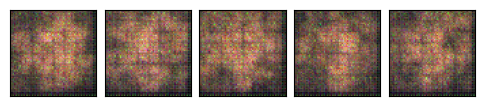

*** Saved checkpoint checkpoints/vae.pt at epoch 12


*** Saved checkpoint checkpoints/vae.pt at epoch 14


*** Saved checkpoint checkpoints/vae.pt at epoch 15


*** Saved checkpoint checkpoints/vae.pt at epoch 17


*** Saved checkpoint checkpoints/vae.pt at epoch 18


*** Saved checkpoint checkpoints/vae.pt at epoch 20
--- EPOCH 21/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (1.668):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (2.091):   7%|▋         | 1/15 [00:00<00:02,  6.55it/s]

train_batch (2.091):  13%|█▎        | 2/15 [00:00<00:00, 13.06it/s]

train_batch (2.304):  13%|█▎        | 2/15 [00:00<00:00, 13.06it/s]

train_batch (2.774):  20%|██        | 3/15 [00:00<00:00, 13.06it/s]

train_batch (2.774):  27%|██▋       | 4/15 [00:00<00:00, 12.71it/s]

train_batch (2.615):  27%|██▋       | 4/15 [00:00<00:00, 12.71it/s]

train_batch (2.877):  33%|███▎      | 5/15 [00:00<00:00, 12.71it/s]

train_batch (2.877):  40%|████      | 6/15 [00:00<00:00, 13.24it/s]

train_batch (2.391):  40%|████      | 6/15 [00:00<00:00, 13.24it/s]

train_batch (2.380):  47%|████▋     | 7/15 [00:00<00:00, 13.24it/s]

train_batch (2.380):  53%|█████▎    | 8/15 [00:00<00:00, 12.47it/s]

train_batch (1.848):  53%|█████▎    | 8/15 [00:00<00:00, 12.47it/s]

train_batch (1.391):  60%|██████    | 9/15 [00:00<00:00, 12.47it/s]

train_batch (1.391):  67%|██████▋   | 10/15 [00:00<00:00, 11.79it/s]

train_batch (1.374):  67%|██████▋   | 10/15 [00:00<00:00, 11.79it/s]

train_batch (1.425):  73%|███████▎  | 11/15 [00:00<00:00, 11.79it/s]

train_batch (1.425):  80%|████████  | 12/15 [00:00<00:00, 11.66it/s]

train_batch (1.292):  80%|████████  | 12/15 [00:01<00:00, 11.66it/s]

train_batch (0.975):  87%|████████▋ | 13/15 [00:01<00:00, 11.66it/s]

train_batch (0.975):  93%|█████████▎| 14/15 [00:01<00:00, 12.01it/s]

train_batch (0.991):  93%|█████████▎| 14/15 [00:01<00:00, 12.01it/s]

train_batch (Avg. Loss 1.893, Accuracy 11.1): 100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

train_batch (Avg. Loss 1.893, Accuracy 11.1): 100%|██████████| 15/15 [00:01<00:00, 12.33it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.530):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.459):  50%|█████     | 1/2 [00:00<00:00,  9.04it/s]

test_batch (1.459): 100%|██████████| 2/2 [00:00<00:00, 17.99it/s]

test_batch (Avg. Loss 1.495, Accuracy 13.4): 100%|██████████| 2/2 [00:00<00:00, 17.99it/s]

test_batch (Avg. Loss 1.495, Accuracy 13.4): 100%|██████████| 2/2 [00:00<00:00, 17.69it/s]

*** Saved checkpoint checkpoints/vae.pt at epoch 21


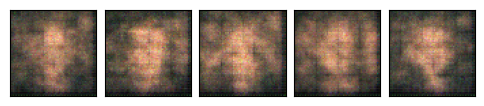

--- EPOCH 31/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (2.613):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (3.105):   7%|▋         | 1/15 [00:00<00:02,  6.99it/s]

train_batch (3.105):  13%|█▎        | 2/15 [00:00<00:00, 13.93it/s]

train_batch (3.788):  13%|█▎        | 2/15 [00:00<00:00, 13.93it/s]

train_batch (3.223):  20%|██        | 3/15 [00:00<00:00, 13.93it/s]

train_batch (3.223):  27%|██▋       | 4/15 [00:00<00:00, 13.95it/s]

train_batch (2.022):  27%|██▋       | 4/15 [00:00<00:00, 13.95it/s]

train_batch (1.366):  33%|███▎      | 5/15 [00:00<00:00, 13.95it/s]

train_batch (1.366):  40%|████      | 6/15 [00:00<00:00, 13.89it/s]

train_batch (1.048):  40%|████      | 6/15 [00:00<00:00, 13.89it/s]

train_batch (0.934):  47%|████▋     | 7/15 [00:00<00:00, 13.89it/s]

train_batch (0.934):  53%|█████▎    | 8/15 [00:00<00:00, 13.78it/s]

train_batch (0.877):  53%|█████▎    | 8/15 [00:00<00:00, 13.78it/s]

train_batch (0.924):  60%|██████    | 9/15 [00:00<00:00, 13.78it/s]

train_batch (0.924):  67%|██████▋   | 10/15 [00:00<00:00, 13.90it/s]

train_batch (0.938):  67%|██████▋   | 10/15 [00:00<00:00, 13.90it/s]

train_batch (0.782):  73%|███████▎  | 11/15 [00:00<00:00, 13.90it/s]

train_batch (0.782):  80%|████████  | 12/15 [00:00<00:00, 13.89it/s]

train_batch (0.758):  80%|████████  | 12/15 [00:00<00:00, 13.89it/s]

train_batch (0.732):  87%|████████▋ | 13/15 [00:01<00:00, 13.89it/s]

train_batch (0.732):  93%|█████████▎| 14/15 [00:01<00:00, 13.90it/s]

train_batch (0.850):  93%|█████████▎| 14/15 [00:01<00:00, 13.90it/s]

train_batch (Avg. Loss 1.597, Accuracy 11.3): 100%|██████████| 15/15 [00:01<00:00, 13.90it/s]

train_batch (Avg. Loss 1.597, Accuracy 11.3): 100%|██████████| 15/15 [00:01<00:00, 13.94it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.308):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.282):  50%|█████     | 1/2 [00:00<00:00,  8.49it/s]

test_batch (1.282): 100%|██████████| 2/2 [00:00<00:00, 16.90it/s]

test_batch (Avg. Loss 1.295, Accuracy 13.2): 100%|██████████| 2/2 [00:00<00:00, 16.90it/s]

test_batch (Avg. Loss 1.295, Accuracy 13.2): 100%|██████████| 2/2 [00:00<00:00, 16.63it/s]

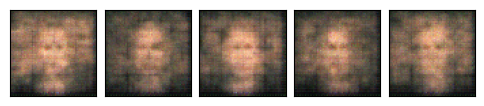

*** Saved checkpoint checkpoints/vae.pt at epoch 33


*** Saved checkpoint checkpoints/vae.pt at epoch 34


--- EPOCH 41/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.955):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.921):   7%|▋         | 1/15 [00:00<00:01,  7.08it/s]

train_batch (0.921):  13%|█▎        | 2/15 [00:00<00:00, 14.10it/s]

train_batch (0.947):  13%|█▎        | 2/15 [00:00<00:00, 14.10it/s]

train_batch (1.027):  20%|██        | 3/15 [00:00<00:00, 14.10it/s]

train_batch (1.027):  27%|██▋       | 4/15 [00:00<00:00, 14.04it/s]

train_batch (1.340):  27%|██▋       | 4/15 [00:00<00:00, 14.04it/s]

train_batch (1.327):  33%|███▎      | 5/15 [00:00<00:00, 14.04it/s]

train_batch (1.327):  40%|████      | 6/15 [00:00<00:00, 14.09it/s]

train_batch (1.064):  40%|████      | 6/15 [00:00<00:00, 14.09it/s]

train_batch (0.887):  47%|████▋     | 7/15 [00:00<00:00, 14.09it/s]

train_batch (0.887):  53%|█████▎    | 8/15 [00:00<00:00, 14.07it/s]

train_batch (0.788):  53%|█████▎    | 8/15 [00:00<00:00, 14.07it/s]

train_batch (0.889):  60%|██████    | 9/15 [00:00<00:00, 14.07it/s]

train_batch (0.889):  67%|██████▋   | 10/15 [00:00<00:00, 14.04it/s]

train_batch (0.944):  67%|██████▋   | 10/15 [00:00<00:00, 14.04it/s]

train_batch (0.943):  73%|███████▎  | 11/15 [00:00<00:00, 14.04it/s]

train_batch (0.943):  80%|████████  | 12/15 [00:00<00:00, 14.04it/s]

train_batch (1.025):  80%|████████  | 12/15 [00:00<00:00, 14.04it/s]

train_batch (1.380):  87%|████████▋ | 13/15 [00:00<00:00, 14.04it/s]

train_batch (1.380):  93%|█████████▎| 14/15 [00:00<00:00, 14.03it/s]

train_batch (1.665):  93%|█████████▎| 14/15 [00:01<00:00, 14.03it/s]

train_batch (Avg. Loss 1.074, Accuracy 11.5): 100%|██████████| 15/15 [00:01<00:00, 14.03it/s]

train_batch (Avg. Loss 1.074, Accuracy 11.5): 100%|██████████| 15/15 [00:01<00:00, 14.06it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.937):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (1.968):  50%|█████     | 1/2 [00:00<00:00,  7.18it/s]

test_batch (1.968): 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]

test_batch (Avg. Loss 1.953, Accuracy 13.3): 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]

test_batch (Avg. Loss 1.953, Accuracy 13.3): 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

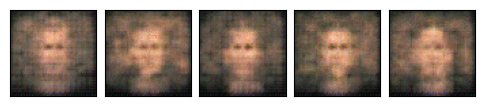

--- EPOCH 51/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.576):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.489):   7%|▋         | 1/15 [00:00<00:01,  7.04it/s]

train_batch (0.489):  13%|█▎        | 2/15 [00:00<00:00, 14.02it/s]

train_batch (0.605):  13%|█▎        | 2/15 [00:00<00:00, 14.02it/s]

train_batch (0.578):  20%|██        | 3/15 [00:00<00:00, 14.02it/s]

train_batch (0.578):  27%|██▋       | 4/15 [00:00<00:00, 13.57it/s]

train_batch (0.572):  27%|██▋       | 4/15 [00:00<00:00, 13.57it/s]

train_batch (0.592):  33%|███▎      | 5/15 [00:00<00:00, 13.57it/s]

train_batch (0.592):  40%|████      | 6/15 [00:00<00:00, 13.55it/s]

train_batch (0.646):  40%|████      | 6/15 [00:00<00:00, 13.55it/s]

train_batch (0.569):  47%|████▋     | 7/15 [00:00<00:00, 13.55it/s]

train_batch (0.569):  53%|█████▎    | 8/15 [00:00<00:00, 13.72it/s]

train_batch (0.532):  53%|█████▎    | 8/15 [00:00<00:00, 13.72it/s]

train_batch (0.543):  60%|██████    | 9/15 [00:00<00:00, 13.72it/s]

train_batch (0.543):  67%|██████▋   | 10/15 [00:00<00:00, 13.77it/s]

train_batch (0.564):  67%|██████▋   | 10/15 [00:00<00:00, 13.77it/s]

train_batch (0.680):  73%|███████▎  | 11/15 [00:00<00:00, 13.77it/s]

train_batch (0.680):  80%|████████  | 12/15 [00:00<00:00, 13.84it/s]

train_batch (0.800):  80%|████████  | 12/15 [00:00<00:00, 13.84it/s]

train_batch (0.938):  87%|████████▋ | 13/15 [00:01<00:00, 13.84it/s]

train_batch (0.938):  93%|█████████▎| 14/15 [00:01<00:00, 13.15it/s]

train_batch (0.874):  93%|█████████▎| 14/15 [00:01<00:00, 13.15it/s]

train_batch (Avg. Loss 0.637, Accuracy 11.5): 100%|██████████| 15/15 [00:01<00:00, 13.15it/s]

train_batch (Avg. Loss 0.637, Accuracy 11.5): 100%|██████████| 15/15 [00:01<00:00, 13.56it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.931):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.845):  50%|█████     | 1/2 [00:00<00:00,  8.99it/s]

test_batch (0.845): 100%|██████████| 2/2 [00:00<00:00, 17.89it/s]

test_batch (Avg. Loss 0.888, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.89it/s]

test_batch (Avg. Loss 0.888, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.59it/s]

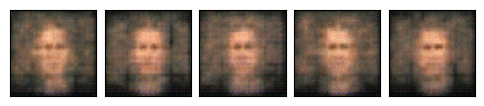

*** Saved checkpoint checkpoints/vae.pt at epoch 58


--- EPOCH 61/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.510):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.546):   7%|▋         | 1/15 [00:00<00:01,  7.06it/s]

train_batch (0.546):  13%|█▎        | 2/15 [00:00<00:00, 14.07it/s]

train_batch (0.591):  13%|█▎        | 2/15 [00:00<00:00, 14.07it/s]

train_batch (0.559):  20%|██        | 3/15 [00:00<00:00, 14.07it/s]

train_batch (0.559):  27%|██▋       | 4/15 [00:00<00:00, 14.10it/s]

train_batch (0.532):  27%|██▋       | 4/15 [00:00<00:00, 14.10it/s]

train_batch (0.661):  33%|███▎      | 5/15 [00:00<00:00, 14.10it/s]

train_batch (0.661):  40%|████      | 6/15 [00:00<00:00, 14.06it/s]

train_batch (0.679):  40%|████      | 6/15 [00:00<00:00, 14.06it/s]

train_batch (0.709):  47%|████▋     | 7/15 [00:00<00:00, 14.06it/s]

train_batch (0.709):  53%|█████▎    | 8/15 [00:00<00:00, 14.02it/s]

train_batch (0.955):  53%|█████▎    | 8/15 [00:00<00:00, 14.02it/s]

train_batch (0.920):  60%|██████    | 9/15 [00:00<00:00, 14.02it/s]

train_batch (0.920):  67%|██████▋   | 10/15 [00:00<00:00, 14.03it/s]

train_batch (0.675):  67%|██████▋   | 10/15 [00:00<00:00, 14.03it/s]

train_batch (0.514):  73%|███████▎  | 11/15 [00:00<00:00, 14.03it/s]

train_batch (0.514):  80%|████████  | 12/15 [00:00<00:00, 14.08it/s]

train_batch (0.570):  80%|████████  | 12/15 [00:00<00:00, 14.08it/s]

train_batch (0.557):  87%|████████▋ | 13/15 [00:00<00:00, 14.08it/s]

train_batch (0.557):  93%|█████████▎| 14/15 [00:00<00:00, 14.07it/s]

train_batch (0.473):  93%|█████████▎| 14/15 [00:01<00:00, 14.07it/s]

train_batch (Avg. Loss 0.630, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 14.07it/s]

train_batch (Avg. Loss 0.630, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 14.12it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.703):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.699):  50%|█████     | 1/2 [00:00<00:00,  8.97it/s]

test_batch (0.699): 100%|██████████| 2/2 [00:00<00:00, 17.85it/s]

test_batch (Avg. Loss 0.701, Accuracy 13.5): 100%|██████████| 2/2 [00:00<00:00, 17.85it/s]

test_batch (Avg. Loss 0.701, Accuracy 13.5): 100%|██████████| 2/2 [00:00<00:00, 17.56it/s]

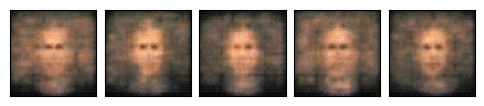

*** Saved checkpoint checkpoints/vae.pt at epoch 68


--- EPOCH 71/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.562):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.563):   7%|▋         | 1/15 [00:00<00:01,  7.20it/s]

train_batch (0.563):  13%|█▎        | 2/15 [00:00<00:00, 14.34it/s]

train_batch (0.582):  13%|█▎        | 2/15 [00:00<00:00, 14.34it/s]

train_batch (0.583):  20%|██        | 3/15 [00:00<00:00, 14.34it/s]

train_batch (0.583):  27%|██▋       | 4/15 [00:00<00:00, 14.38it/s]

train_batch (0.544):  27%|██▋       | 4/15 [00:00<00:00, 14.38it/s]

train_batch (0.504):  33%|███▎      | 5/15 [00:00<00:00, 14.38it/s]

train_batch (0.504):  40%|████      | 6/15 [00:00<00:00, 14.42it/s]

train_batch (0.500):  40%|████      | 6/15 [00:00<00:00, 14.42it/s]

train_batch (0.629):  47%|████▋     | 7/15 [00:00<00:00, 14.42it/s]

train_batch (0.629):  53%|█████▎    | 8/15 [00:00<00:00, 14.34it/s]

train_batch (0.677):  53%|█████▎    | 8/15 [00:00<00:00, 14.34it/s]

train_batch (0.618):  60%|██████    | 9/15 [00:00<00:00, 14.34it/s]

train_batch (0.618):  67%|██████▋   | 10/15 [00:00<00:00, 13.98it/s]

train_batch (0.533):  67%|██████▋   | 10/15 [00:00<00:00, 13.98it/s]

train_batch (0.430):  73%|███████▎  | 11/15 [00:00<00:00, 13.98it/s]

train_batch (0.430):  80%|████████  | 12/15 [00:00<00:00, 13.70it/s]

train_batch (0.481):  80%|████████  | 12/15 [00:00<00:00, 13.70it/s]

train_batch (0.494):  87%|████████▋ | 13/15 [00:00<00:00, 13.70it/s]

train_batch (0.494):  93%|█████████▎| 14/15 [00:00<00:00, 13.83it/s]

train_batch (0.683):  93%|█████████▎| 14/15 [00:01<00:00, 13.83it/s]

train_batch (Avg. Loss 0.559, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 13.83it/s]

train_batch (Avg. Loss 0.559, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 14.10it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.980):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.931):  50%|█████     | 1/2 [00:00<00:00,  9.18it/s]

test_batch (0.931): 100%|██████████| 2/2 [00:00<00:00, 18.26it/s]

test_batch (Avg. Loss 0.956, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 18.26it/s]

test_batch (Avg. Loss 0.956, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 17.95it/s]

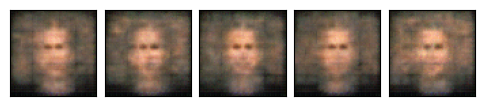

--- EPOCH 81/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.411):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.435):   7%|▋         | 1/15 [00:00<00:02,  6.49it/s]

train_batch (0.435):  13%|█▎        | 2/15 [00:00<00:01, 12.93it/s]

train_batch (0.524):  13%|█▎        | 2/15 [00:00<00:01, 12.93it/s]

train_batch (0.517):  20%|██        | 3/15 [00:00<00:00, 12.93it/s]

train_batch (0.517):  27%|██▋       | 4/15 [00:00<00:00, 13.63it/s]

train_batch (0.566):  27%|██▋       | 4/15 [00:00<00:00, 13.63it/s]

train_batch (0.598):  33%|███▎      | 5/15 [00:00<00:00, 13.63it/s]

train_batch (0.598):  40%|████      | 6/15 [00:00<00:00, 13.57it/s]

train_batch (0.550):  40%|████      | 6/15 [00:00<00:00, 13.57it/s]

train_batch (0.482):  47%|████▋     | 7/15 [00:00<00:00, 13.57it/s]

train_batch (0.482):  53%|█████▎    | 8/15 [00:00<00:00, 13.88it/s]

train_batch (0.373):  53%|█████▎    | 8/15 [00:00<00:00, 13.88it/s]

train_batch (0.399):  60%|██████    | 9/15 [00:00<00:00, 13.88it/s]

train_batch (0.399):  67%|██████▋   | 10/15 [00:00<00:00, 13.99it/s]

train_batch (0.416):  67%|██████▋   | 10/15 [00:00<00:00, 13.99it/s]

train_batch (0.419):  73%|███████▎  | 11/15 [00:00<00:00, 13.99it/s]

train_batch (0.419):  80%|████████  | 12/15 [00:00<00:00, 14.10it/s]

train_batch (0.464):  80%|████████  | 12/15 [00:00<00:00, 14.10it/s]

train_batch (0.524):  87%|████████▋ | 13/15 [00:01<00:00, 14.10it/s]

train_batch (0.524):  93%|█████████▎| 14/15 [00:01<00:00, 13.93it/s]

train_batch (0.536):  93%|█████████▎| 14/15 [00:01<00:00, 13.93it/s]

train_batch (Avg. Loss 0.481, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 13.93it/s]

train_batch (Avg. Loss 0.481, Accuracy 11.6): 100%|██████████| 15/15 [00:01<00:00, 13.95it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.726):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.632):  50%|█████     | 1/2 [00:00<00:00,  9.09it/s]

test_batch (0.632): 100%|██████████| 2/2 [00:00<00:00, 18.08it/s]

test_batch (Avg. Loss 0.679, Accuracy 14.6): 100%|██████████| 2/2 [00:00<00:00, 18.08it/s]

test_batch (Avg. Loss 0.679, Accuracy 14.6): 100%|██████████| 2/2 [00:00<00:00, 17.77it/s]

*** Saved checkpoint checkpoints/vae.pt at epoch 81


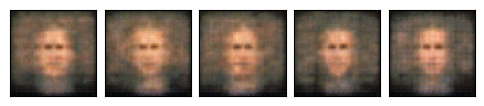

--- EPOCH 91/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.640):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.514):   7%|▋         | 1/15 [00:00<00:01,  7.00it/s]

train_batch (0.514):  13%|█▎        | 2/15 [00:00<00:00, 13.95it/s]

train_batch (0.561):  13%|█▎        | 2/15 [00:00<00:00, 13.95it/s]

train_batch (0.661):  20%|██        | 3/15 [00:00<00:00, 13.95it/s]

train_batch (0.661):  27%|██▋       | 4/15 [00:00<00:00, 13.92it/s]

train_batch (0.636):  27%|██▋       | 4/15 [00:00<00:00, 13.92it/s]

train_batch (0.659):  33%|███▎      | 5/15 [00:00<00:00, 13.92it/s]

train_batch (0.659):  40%|████      | 6/15 [00:00<00:00, 14.00it/s]

train_batch (0.553):  40%|████      | 6/15 [00:00<00:00, 14.00it/s]

train_batch (0.653):  47%|████▋     | 7/15 [00:00<00:00, 14.00it/s]

train_batch (0.653):  53%|█████▎    | 8/15 [00:00<00:00, 13.96it/s]

train_batch (0.665):  53%|█████▎    | 8/15 [00:00<00:00, 13.96it/s]

train_batch (0.582):  60%|██████    | 9/15 [00:00<00:00, 13.96it/s]

train_batch (0.582):  67%|██████▋   | 10/15 [00:00<00:00, 14.05it/s]

train_batch (0.468):  67%|██████▋   | 10/15 [00:00<00:00, 14.05it/s]

train_batch (0.484):  73%|███████▎  | 11/15 [00:00<00:00, 14.05it/s]

train_batch (0.484):  80%|████████  | 12/15 [00:00<00:00, 14.04it/s]

train_batch (0.493):  80%|████████  | 12/15 [00:00<00:00, 14.04it/s]

train_batch (0.560):  87%|████████▋ | 13/15 [00:01<00:00, 14.04it/s]

train_batch (0.560):  93%|█████████▎| 14/15 [00:01<00:00, 13.64it/s]

train_batch (0.560):  93%|█████████▎| 14/15 [00:01<00:00, 13.64it/s]

train_batch (Avg. Loss 0.579, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.64it/s]

train_batch (Avg. Loss 0.579, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.82it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.797):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.841):  50%|█████     | 1/2 [00:00<00:00,  9.00it/s]

test_batch (0.841): 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]

test_batch (Avg. Loss 0.819, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]

test_batch (Avg. Loss 0.819, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.61it/s]

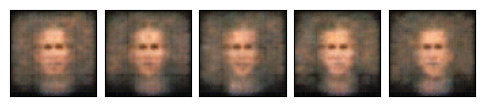

--- EPOCH 101/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.461):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.374):   7%|▋         | 1/15 [00:00<00:01,  7.03it/s]

train_batch (0.374):  13%|█▎        | 2/15 [00:00<00:00, 14.00it/s]

train_batch (0.396):  13%|█▎        | 2/15 [00:00<00:00, 14.00it/s]

train_batch (0.415):  20%|██        | 3/15 [00:00<00:00, 14.00it/s]

train_batch (0.415):  27%|██▋       | 4/15 [00:00<00:00, 13.95it/s]

train_batch (0.469):  27%|██▋       | 4/15 [00:00<00:00, 13.95it/s]

train_batch (0.601):  33%|███▎      | 5/15 [00:00<00:00, 13.95it/s]

train_batch (0.601):  40%|████      | 6/15 [00:00<00:00, 13.98it/s]

train_batch (0.644):  40%|████      | 6/15 [00:00<00:00, 13.98it/s]

train_batch (0.703):  47%|████▋     | 7/15 [00:00<00:00, 13.98it/s]

train_batch (0.703):  53%|█████▎    | 8/15 [00:00<00:00, 13.99it/s]

train_batch (0.632):  53%|█████▎    | 8/15 [00:00<00:00, 13.99it/s]

train_batch (0.464):  60%|██████    | 9/15 [00:00<00:00, 13.99it/s]

train_batch (0.464):  67%|██████▋   | 10/15 [00:00<00:00, 13.63it/s]

train_batch (0.422):  67%|██████▋   | 10/15 [00:00<00:00, 13.63it/s]

train_batch (0.427):  73%|███████▎  | 11/15 [00:00<00:00, 13.63it/s]

train_batch (0.427):  80%|████████  | 12/15 [00:00<00:00, 13.74it/s]

train_batch (0.437):  80%|████████  | 12/15 [00:00<00:00, 13.74it/s]

train_batch (0.444):  87%|████████▋ | 13/15 [00:01<00:00, 13.74it/s]

train_batch (0.444):  93%|█████████▎| 14/15 [00:01<00:00, 13.81it/s]

train_batch (0.391):  93%|█████████▎| 14/15 [00:01<00:00, 13.81it/s]

train_batch (Avg. Loss 0.485, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.81it/s]

train_batch (Avg. Loss 0.485, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.89it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.545):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.542):  50%|█████     | 1/2 [00:00<00:00,  8.91it/s]

test_batch (0.542): 100%|██████████| 2/2 [00:00<00:00, 17.73it/s]

test_batch (Avg. Loss 0.544, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.73it/s]

test_batch (Avg. Loss 0.544, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.43it/s]

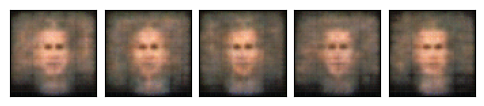

--- EPOCH 111/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.396):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.376):   7%|▋         | 1/15 [00:00<00:02,  6.99it/s]

train_batch (0.376):  13%|█▎        | 2/15 [00:00<00:00, 13.93it/s]

train_batch (0.474):  13%|█▎        | 2/15 [00:00<00:00, 13.93it/s]

train_batch (0.475):  20%|██        | 3/15 [00:00<00:00, 13.93it/s]

train_batch (0.475):  27%|██▋       | 4/15 [00:00<00:00, 14.00it/s]

train_batch (0.570):  27%|██▋       | 4/15 [00:00<00:00, 14.00it/s]

train_batch (0.659):  33%|███▎      | 5/15 [00:00<00:00, 14.00it/s]

train_batch (0.659):  40%|████      | 6/15 [00:00<00:00, 13.88it/s]

train_batch (0.797):  40%|████      | 6/15 [00:00<00:00, 13.88it/s]

train_batch (0.590):  47%|████▋     | 7/15 [00:00<00:00, 13.88it/s]

train_batch (0.590):  53%|█████▎    | 8/15 [00:00<00:00, 13.96it/s]

train_batch (0.494):  53%|█████▎    | 8/15 [00:00<00:00, 13.96it/s]

train_batch (0.463):  60%|██████    | 9/15 [00:00<00:00, 13.96it/s]

train_batch (0.463):  67%|██████▋   | 10/15 [00:00<00:00, 13.94it/s]

train_batch (0.417):  67%|██████▋   | 10/15 [00:00<00:00, 13.94it/s]

train_batch (0.409):  73%|███████▎  | 11/15 [00:00<00:00, 13.94it/s]

train_batch (0.409):  80%|████████  | 12/15 [00:00<00:00, 13.89it/s]

train_batch (0.389):  80%|████████  | 12/15 [00:00<00:00, 13.89it/s]

train_batch (0.395):  87%|████████▋ | 13/15 [00:01<00:00, 13.89it/s]

train_batch (0.395):  93%|█████████▎| 14/15 [00:01<00:00, 13.93it/s]

train_batch (0.449):  93%|█████████▎| 14/15 [00:01<00:00, 13.93it/s]

train_batch (Avg. Loss 0.490, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.93it/s]

train_batch (Avg. Loss 0.490, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 14.00it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.635):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.629):  50%|█████     | 1/2 [00:00<00:00,  9.05it/s]

test_batch (0.629): 100%|██████████| 2/2 [00:00<00:00, 18.01it/s]

test_batch (Avg. Loss 0.632, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 18.01it/s]

test_batch (Avg. Loss 0.632, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.71it/s]

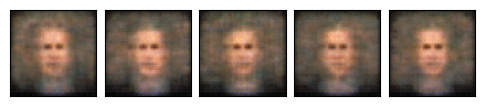

--- EPOCH 121/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.481):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.429):   7%|▋         | 1/15 [00:00<00:01,  7.02it/s]

train_batch (0.429):  13%|█▎        | 2/15 [00:00<00:00, 13.99it/s]

train_batch (0.351):  13%|█▎        | 2/15 [00:00<00:00, 13.99it/s]

train_batch (0.357):  20%|██        | 3/15 [00:00<00:00, 13.99it/s]

train_batch (0.357):  27%|██▋       | 4/15 [00:00<00:00, 13.12it/s]

train_batch (0.359):  27%|██▋       | 4/15 [00:00<00:00, 13.12it/s]

train_batch (0.377):  33%|███▎      | 5/15 [00:00<00:00, 13.12it/s]

train_batch (0.377):  40%|████      | 6/15 [00:00<00:00, 12.44it/s]

train_batch (0.349):  40%|████      | 6/15 [00:00<00:00, 12.44it/s]

train_batch (0.356):  47%|████▋     | 7/15 [00:00<00:00, 12.44it/s]

train_batch (0.356):  53%|█████▎    | 8/15 [00:00<00:00, 12.79it/s]

train_batch (0.354):  53%|█████▎    | 8/15 [00:00<00:00, 12.79it/s]

train_batch (0.360):  60%|██████    | 9/15 [00:00<00:00, 12.79it/s]

train_batch (0.360):  67%|██████▋   | 10/15 [00:00<00:00, 13.19it/s]

train_batch (0.345):  67%|██████▋   | 10/15 [00:00<00:00, 13.19it/s]

train_batch (0.355):  73%|███████▎  | 11/15 [00:00<00:00, 13.19it/s]

train_batch (0.355):  80%|████████  | 12/15 [00:00<00:00, 12.58it/s]

train_batch (0.387):  80%|████████  | 12/15 [00:01<00:00, 12.58it/s]

train_batch (0.433):  87%|████████▋ | 13/15 [00:01<00:00, 12.58it/s]

train_batch (0.433):  93%|█████████▎| 14/15 [00:01<00:00, 12.43it/s]

train_batch (0.427):  93%|█████████▎| 14/15 [00:01<00:00, 12.43it/s]

train_batch (Avg. Loss 0.381, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 12.43it/s]

train_batch (Avg. Loss 0.381, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 12.82it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.558):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.598):  50%|█████     | 1/2 [00:00<00:00,  8.91it/s]

test_batch (0.598): 100%|██████████| 2/2 [00:00<00:00, 17.72it/s]

test_batch (Avg. Loss 0.578, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.72it/s]

test_batch (Avg. Loss 0.578, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.42it/s]

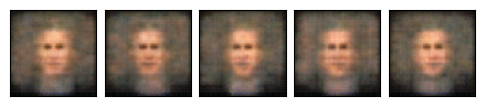

--- EPOCH 131/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.428):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.445):   7%|▋         | 1/15 [00:00<00:02,  6.97it/s]

train_batch (0.445):  13%|█▎        | 2/15 [00:00<00:00, 13.88it/s]

train_batch (0.400):  13%|█▎        | 2/15 [00:00<00:00, 13.88it/s]

train_batch (0.360):  20%|██        | 3/15 [00:00<00:00, 13.88it/s]

train_batch (0.360):  27%|██▋       | 4/15 [00:00<00:00, 13.94it/s]

train_batch (0.365):  27%|██▋       | 4/15 [00:00<00:00, 13.94it/s]

train_batch (0.372):  33%|███▎      | 5/15 [00:00<00:00, 13.94it/s]

train_batch (0.372):  40%|████      | 6/15 [00:00<00:00, 13.97it/s]

train_batch (0.379):  40%|████      | 6/15 [00:00<00:00, 13.97it/s]

train_batch (0.410):  47%|████▋     | 7/15 [00:00<00:00, 13.97it/s]

train_batch (0.410):  53%|█████▎    | 8/15 [00:00<00:00, 14.01it/s]

train_batch (0.621):  53%|█████▎    | 8/15 [00:00<00:00, 14.01it/s]

train_batch (0.669):  60%|██████    | 9/15 [00:00<00:00, 14.01it/s]

train_batch (0.669):  67%|██████▋   | 10/15 [00:00<00:00, 14.01it/s]

train_batch (0.543):  67%|██████▋   | 10/15 [00:00<00:00, 14.01it/s]

train_batch (0.593):  73%|███████▎  | 11/15 [00:00<00:00, 14.01it/s]

train_batch (0.593):  80%|████████  | 12/15 [00:00<00:00, 13.96it/s]

train_batch (0.609):  80%|████████  | 12/15 [00:00<00:00, 13.96it/s]

train_batch (0.497):  87%|████████▋ | 13/15 [00:01<00:00, 13.96it/s]

train_batch (0.497):  93%|█████████▎| 14/15 [00:01<00:00, 13.94it/s]

train_batch (0.355):  93%|█████████▎| 14/15 [00:01<00:00, 13.94it/s]

train_batch (Avg. Loss 0.470, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.94it/s]

train_batch (Avg. Loss 0.470, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 14.03it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.491):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.425):  50%|█████     | 1/2 [00:00<00:00,  8.77it/s]

test_batch (0.425): 100%|██████████| 2/2 [00:00<00:00, 17.47it/s]

test_batch (Avg. Loss 0.458, Accuracy 14.0): 100%|██████████| 2/2 [00:00<00:00, 17.47it/s]

test_batch (Avg. Loss 0.458, Accuracy 14.0): 100%|██████████| 2/2 [00:00<00:00, 17.18it/s]

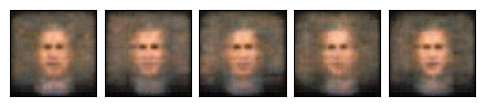

--- EPOCH 141/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.414):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.459):   7%|▋         | 1/15 [00:00<00:01,  7.08it/s]

train_batch (0.459):  13%|█▎        | 2/15 [00:00<00:00, 14.10it/s]

train_batch (0.572):  13%|█▎        | 2/15 [00:00<00:00, 14.10it/s]

train_batch (0.602):  20%|██        | 3/15 [00:00<00:00, 14.10it/s]

train_batch (0.602):  27%|██▋       | 4/15 [00:00<00:00, 13.26it/s]

train_batch (0.550):  27%|██▋       | 4/15 [00:00<00:00, 13.26it/s]

train_batch (0.377):  33%|███▎      | 5/15 [00:00<00:00, 13.26it/s]

train_batch (0.377):  40%|████      | 6/15 [00:00<00:00, 13.38it/s]

train_batch (0.347):  40%|████      | 6/15 [00:00<00:00, 13.38it/s]

train_batch (0.349):  47%|████▋     | 7/15 [00:00<00:00, 13.38it/s]

train_batch (0.349):  53%|█████▎    | 8/15 [00:00<00:00, 13.61it/s]

train_batch (0.385):  53%|█████▎    | 8/15 [00:00<00:00, 13.61it/s]

train_batch (0.417):  60%|██████    | 9/15 [00:00<00:00, 13.61it/s]

train_batch (0.417):  67%|██████▋   | 10/15 [00:00<00:00, 13.74it/s]

train_batch (0.467):  67%|██████▋   | 10/15 [00:00<00:00, 13.74it/s]

train_batch (0.550):  73%|███████▎  | 11/15 [00:00<00:00, 13.74it/s]

train_batch (0.550):  80%|████████  | 12/15 [00:00<00:00, 13.86it/s]

train_batch (0.465):  80%|████████  | 12/15 [00:00<00:00, 13.86it/s]

train_batch (0.413):  87%|████████▋ | 13/15 [00:01<00:00, 13.86it/s]

train_batch (0.413):  93%|█████████▎| 14/15 [00:01<00:00, 13.70it/s]

train_batch (0.406):  93%|█████████▎| 14/15 [00:01<00:00, 13.70it/s]

train_batch (Avg. Loss 0.452, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.70it/s]

train_batch (Avg. Loss 0.452, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.75it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.532):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.572):  50%|█████     | 1/2 [00:00<00:00,  9.09it/s]

test_batch (0.572): 100%|██████████| 2/2 [00:00<00:00, 18.09it/s]

test_batch (Avg. Loss 0.552, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 18.09it/s]

test_batch (Avg. Loss 0.552, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 17.79it/s]

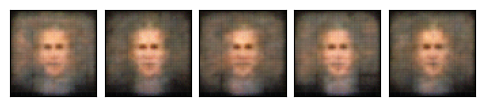

--- EPOCH 151/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.334):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.373):   7%|▋         | 1/15 [00:00<00:02,  7.00it/s]

train_batch (0.373):  13%|█▎        | 2/15 [00:00<00:00, 13.94it/s]

train_batch (0.354):  13%|█▎        | 2/15 [00:00<00:00, 13.94it/s]

train_batch (0.342):  20%|██        | 3/15 [00:00<00:00, 13.94it/s]

train_batch (0.342):  27%|██▋       | 4/15 [00:00<00:00, 13.94it/s]

train_batch (0.334):  27%|██▋       | 4/15 [00:00<00:00, 13.94it/s]

train_batch (0.406):  33%|███▎      | 5/15 [00:00<00:00, 13.94it/s]

train_batch (0.406):  40%|████      | 6/15 [00:00<00:00, 14.03it/s]

train_batch (0.421):  40%|████      | 6/15 [00:00<00:00, 14.03it/s]

train_batch (0.423):  47%|████▋     | 7/15 [00:00<00:00, 14.03it/s]

train_batch (0.423):  53%|█████▎    | 8/15 [00:00<00:00, 13.99it/s]

train_batch (0.378):  53%|█████▎    | 8/15 [00:00<00:00, 13.99it/s]

train_batch (0.308):  60%|██████    | 9/15 [00:00<00:00, 13.99it/s]

train_batch (0.308):  67%|██████▋   | 10/15 [00:00<00:00, 13.45it/s]

train_batch (0.271):  67%|██████▋   | 10/15 [00:00<00:00, 13.45it/s]

train_batch (0.338):  73%|███████▎  | 11/15 [00:00<00:00, 13.45it/s]

train_batch (0.338):  80%|████████  | 12/15 [00:00<00:00, 13.57it/s]

train_batch (0.449):  80%|████████  | 12/15 [00:00<00:00, 13.57it/s]

train_batch (0.605):  87%|████████▋ | 13/15 [00:01<00:00, 13.57it/s]

train_batch (0.605):  93%|█████████▎| 14/15 [00:01<00:00, 13.66it/s]

train_batch (0.640):  93%|█████████▎| 14/15 [00:01<00:00, 13.66it/s]

train_batch (Avg. Loss 0.398, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.66it/s]

train_batch (Avg. Loss 0.398, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.65it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.766):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.716):  50%|█████     | 1/2 [00:00<00:00,  8.79it/s]

test_batch (0.716): 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]

test_batch (Avg. Loss 0.741, Accuracy 13.9): 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]

test_batch (Avg. Loss 0.741, Accuracy 13.9): 100%|██████████| 2/2 [00:00<00:00, 17.20it/s]

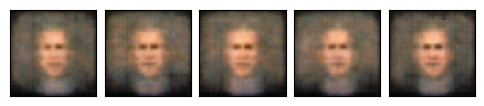

--- EPOCH 161/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.304):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.292):   7%|▋         | 1/15 [00:00<00:02,  6.98it/s]

train_batch (0.292):  13%|█▎        | 2/15 [00:00<00:00, 13.91it/s]

train_batch (0.306):  13%|█▎        | 2/15 [00:00<00:00, 13.91it/s]

train_batch (0.278):  20%|██        | 3/15 [00:00<00:00, 13.91it/s]

train_batch (0.278):  27%|██▋       | 4/15 [00:00<00:00, 13.75it/s]

train_batch (0.313):  27%|██▋       | 4/15 [00:00<00:00, 13.75it/s]

train_batch (0.349):  33%|███▎      | 5/15 [00:00<00:00, 13.75it/s]

train_batch (0.349):  40%|████      | 6/15 [00:00<00:00, 13.24it/s]

train_batch (0.336):  40%|████      | 6/15 [00:00<00:00, 13.24it/s]

train_batch (0.316):  47%|████▋     | 7/15 [00:00<00:00, 13.24it/s]

train_batch (0.316):  53%|█████▎    | 8/15 [00:00<00:00, 13.38it/s]

train_batch (0.314):  53%|█████▎    | 8/15 [00:00<00:00, 13.38it/s]

train_batch (0.334):  60%|██████    | 9/15 [00:00<00:00, 13.38it/s]

train_batch (0.334):  67%|██████▋   | 10/15 [00:00<00:00, 13.17it/s]

train_batch (0.313):  67%|██████▋   | 10/15 [00:00<00:00, 13.17it/s]

train_batch (0.343):  73%|███████▎  | 11/15 [00:00<00:00, 13.17it/s]

train_batch (0.343):  80%|████████  | 12/15 [00:00<00:00, 13.42it/s]

train_batch (0.317):  80%|████████  | 12/15 [00:00<00:00, 13.42it/s]

train_batch (0.330):  87%|████████▋ | 13/15 [00:01<00:00, 13.42it/s]

train_batch (0.330):  93%|█████████▎| 14/15 [00:01<00:00, 13.05it/s]

train_batch (0.384):  93%|█████████▎| 14/15 [00:01<00:00, 13.05it/s]

train_batch (Avg. Loss 0.322, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.05it/s]

train_batch (Avg. Loss 0.322, Accuracy 11.7): 100%|██████████| 15/15 [00:01<00:00, 13.27it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.454):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.450):  50%|█████     | 1/2 [00:00<00:00,  9.04it/s]

test_batch (0.450): 100%|██████████| 2/2 [00:00<00:00, 18.00it/s]

test_batch (Avg. Loss 0.452, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 18.00it/s]

test_batch (Avg. Loss 0.452, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.71it/s]

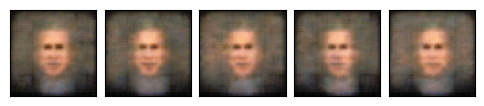

--- EPOCH 171/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.328):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.298):   7%|▋         | 1/15 [00:00<00:02,  6.92it/s]

train_batch (0.298):  13%|█▎        | 2/15 [00:00<00:00, 13.79it/s]

train_batch (0.326):  13%|█▎        | 2/15 [00:00<00:00, 13.79it/s]

train_batch (0.315):  20%|██        | 3/15 [00:00<00:00, 13.79it/s]

train_batch (0.315):  27%|██▋       | 4/15 [00:00<00:00, 13.51it/s]

train_batch (0.322):  27%|██▋       | 4/15 [00:00<00:00, 13.51it/s]

train_batch (0.363):  33%|███▎      | 5/15 [00:00<00:00, 13.51it/s]

train_batch (0.363):  40%|████      | 6/15 [00:00<00:00, 13.61it/s]

train_batch (0.339):  40%|████      | 6/15 [00:00<00:00, 13.61it/s]

train_batch (0.374):  47%|████▋     | 7/15 [00:00<00:00, 13.61it/s]

train_batch (0.374):  53%|█████▎    | 8/15 [00:00<00:00, 12.26it/s]

train_batch (0.381):  53%|█████▎    | 8/15 [00:00<00:00, 12.26it/s]

train_batch (0.376):  60%|██████    | 9/15 [00:00<00:00, 12.26it/s]

train_batch (0.376):  67%|██████▋   | 10/15 [00:00<00:00, 11.91it/s]

train_batch (0.414):  67%|██████▋   | 10/15 [00:00<00:00, 11.91it/s]

train_batch (0.464):  73%|███████▎  | 11/15 [00:00<00:00, 11.91it/s]

train_batch (0.464):  80%|████████  | 12/15 [00:00<00:00, 12.58it/s]

train_batch (0.364):  80%|████████  | 12/15 [00:01<00:00, 12.58it/s]

train_batch (0.324):  87%|████████▋ | 13/15 [00:01<00:00, 12.58it/s]

train_batch (0.324):  93%|█████████▎| 14/15 [00:01<00:00, 13.05it/s]

train_batch (0.274):  93%|█████████▎| 14/15 [00:01<00:00, 13.05it/s]

train_batch (Avg. Loss 0.351, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.05it/s]

train_batch (Avg. Loss 0.351, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.00it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.424):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.420):  50%|█████     | 1/2 [00:00<00:00,  8.45it/s]

test_batch (0.420): 100%|██████████| 2/2 [00:00<00:00, 16.83it/s]

test_batch (Avg. Loss 0.422, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 16.83it/s]

test_batch (Avg. Loss 0.422, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 16.57it/s]

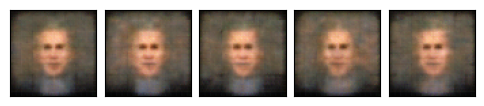

--- EPOCH 181/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.405):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.440):   7%|▋         | 1/15 [00:00<00:01,  7.07it/s]

train_batch (0.440):  13%|█▎        | 2/15 [00:00<00:00, 14.09it/s]

train_batch (0.451):  13%|█▎        | 2/15 [00:00<00:00, 14.09it/s]

train_batch (0.386):  20%|██        | 3/15 [00:00<00:00, 14.09it/s]

train_batch (0.386):  27%|██▋       | 4/15 [00:00<00:00, 13.46it/s]

train_batch (0.313):  27%|██▋       | 4/15 [00:00<00:00, 13.46it/s]

train_batch (0.300):  33%|███▎      | 5/15 [00:00<00:00, 13.46it/s]

train_batch (0.300):  40%|████      | 6/15 [00:00<00:00, 13.14it/s]

train_batch (0.272):  40%|████      | 6/15 [00:00<00:00, 13.14it/s]

train_batch (0.322):  47%|████▋     | 7/15 [00:00<00:00, 13.14it/s]

train_batch (0.322):  53%|█████▎    | 8/15 [00:00<00:00, 12.98it/s]

train_batch (0.364):  53%|█████▎    | 8/15 [00:00<00:00, 12.98it/s]

train_batch (0.381):  60%|██████    | 9/15 [00:00<00:00, 12.98it/s]

train_batch (0.381):  67%|██████▋   | 10/15 [00:00<00:00, 12.66it/s]

train_batch (0.379):  67%|██████▋   | 10/15 [00:00<00:00, 12.66it/s]

train_batch (0.432):  73%|███████▎  | 11/15 [00:00<00:00, 12.66it/s]

train_batch (0.432):  80%|████████  | 12/15 [00:00<00:00, 13.12it/s]

train_batch (0.390):  80%|████████  | 12/15 [00:00<00:00, 13.12it/s]

train_batch (0.331):  87%|████████▋ | 13/15 [00:01<00:00, 13.12it/s]

train_batch (0.331):  93%|█████████▎| 14/15 [00:01<00:00, 13.39it/s]

train_batch (0.286):  93%|█████████▎| 14/15 [00:01<00:00, 13.39it/s]

train_batch (Avg. Loss 0.363, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.39it/s]

train_batch (Avg. Loss 0.363, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 13.31it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.398):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.432):  50%|█████     | 1/2 [00:00<00:00,  8.79it/s]

test_batch (0.432): 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]

test_batch (Avg. Loss 0.415, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]

test_batch (Avg. Loss 0.415, Accuracy 13.6): 100%|██████████| 2/2 [00:00<00:00, 17.21it/s]

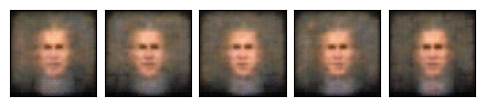

--- EPOCH 191/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.296):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.301):   7%|▋         | 1/15 [00:00<00:02,  6.62it/s]

train_batch (0.301):  13%|█▎        | 2/15 [00:00<00:00, 13.20it/s]

train_batch (0.293):  13%|█▎        | 2/15 [00:00<00:00, 13.20it/s]

train_batch (0.305):  20%|██        | 3/15 [00:00<00:00, 13.20it/s]

train_batch (0.305):  27%|██▋       | 4/15 [00:00<00:00, 13.77it/s]

train_batch (0.253):  27%|██▋       | 4/15 [00:00<00:00, 13.77it/s]

train_batch (0.363):  33%|███▎      | 5/15 [00:00<00:00, 13.77it/s]

train_batch (0.363):  40%|████      | 6/15 [00:00<00:00, 13.88it/s]

train_batch (0.329):  40%|████      | 6/15 [00:00<00:00, 13.88it/s]

train_batch (0.339):  47%|████▋     | 7/15 [00:00<00:00, 13.88it/s]

train_batch (0.339):  53%|█████▎    | 8/15 [00:00<00:00, 13.95it/s]

train_batch (0.298):  53%|█████▎    | 8/15 [00:00<00:00, 13.95it/s]

train_batch (0.293):  60%|██████    | 9/15 [00:00<00:00, 13.95it/s]

train_batch (0.293):  67%|██████▋   | 10/15 [00:00<00:00, 14.03it/s]

train_batch (0.320):  67%|██████▋   | 10/15 [00:00<00:00, 14.03it/s]

train_batch (0.320):  73%|███████▎  | 11/15 [00:00<00:00, 14.03it/s]

train_batch (0.320):  80%|████████  | 12/15 [00:00<00:00, 14.05it/s]

train_batch (0.342):  80%|████████  | 12/15 [00:00<00:00, 14.05it/s]

train_batch (0.328):  87%|████████▋ | 13/15 [00:01<00:00, 14.05it/s]

train_batch (0.328):  93%|█████████▎| 14/15 [00:01<00:00, 14.08it/s]

train_batch (0.282):  93%|█████████▎| 14/15 [00:01<00:00, 14.08it/s]

train_batch (Avg. Loss 0.311, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 14.08it/s]

train_batch (Avg. Loss 0.311, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 14.04it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.378):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.404):  50%|█████     | 1/2 [00:00<00:00,  8.92it/s]

test_batch (0.404): 100%|██████████| 2/2 [00:00<00:00, 17.75it/s]

test_batch (Avg. Loss 0.391, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.75it/s]

test_batch (Avg. Loss 0.391, Accuracy 13.8): 100%|██████████| 2/2 [00:00<00:00, 17.46it/s]

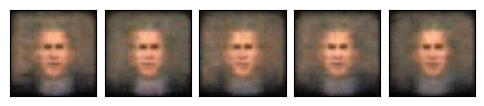

--- EPOCH 200/200 ---


train_batch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.327):   0%|          | 0/15 [00:00<?, ?it/s]

train_batch (0.327):   7%|▋         | 1/15 [00:00<00:01,  7.86it/s]

train_batch (0.333):   7%|▋         | 1/15 [00:00<00:01,  7.86it/s]

train_batch (0.333):  13%|█▎        | 2/15 [00:00<00:01,  8.89it/s]

train_batch (0.309):  13%|█▎        | 2/15 [00:00<00:01,  8.89it/s]

train_batch (0.289):  20%|██        | 3/15 [00:00<00:01,  8.89it/s]

train_batch (0.289):  27%|██▋       | 4/15 [00:00<00:01,  9.74it/s]

train_batch (0.305):  27%|██▋       | 4/15 [00:00<00:01,  9.74it/s]

train_batch (0.351):  33%|███▎      | 5/15 [00:00<00:01,  9.74it/s]

train_batch (0.351):  40%|████      | 6/15 [00:00<00:00, 10.87it/s]

train_batch (0.356):  40%|████      | 6/15 [00:00<00:00, 10.87it/s]

train_batch (0.400):  47%|████▋     | 7/15 [00:00<00:00, 10.87it/s]

train_batch (0.400):  53%|█████▎    | 8/15 [00:00<00:00, 10.98it/s]

train_batch (0.428):  53%|█████▎    | 8/15 [00:00<00:00, 10.98it/s]

train_batch (0.333):  60%|██████    | 9/15 [00:00<00:00, 10.98it/s]

train_batch (0.333):  67%|██████▋   | 10/15 [00:00<00:00, 10.34it/s]

train_batch (0.314):  67%|██████▋   | 10/15 [00:01<00:00, 10.34it/s]

train_batch (0.312):  73%|███████▎  | 11/15 [00:01<00:00, 10.34it/s]

train_batch (0.312):  80%|████████  | 12/15 [00:01<00:00, 10.54it/s]

train_batch (0.300):  80%|████████  | 12/15 [00:01<00:00, 10.54it/s]

train_batch (0.301):  87%|████████▋ | 13/15 [00:01<00:00, 10.54it/s]

train_batch (0.301):  93%|█████████▎| 14/15 [00:01<00:00, 10.34it/s]

train_batch (0.298):  93%|█████████▎| 14/15 [00:01<00:00, 10.34it/s]

train_batch (Avg. Loss 0.331, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 10.34it/s]

train_batch (Avg. Loss 0.331, Accuracy 11.8): 100%|██████████| 15/15 [00:01<00:00, 10.50it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.375):   0%|          | 0/2 [00:00<?, ?it/s]

test_batch (0.418):  50%|█████     | 1/2 [00:00<00:00,  8.89it/s]

test_batch (0.418): 100%|██████████| 2/2 [00:00<00:00, 17.69it/s]

test_batch (Avg. Loss 0.396, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 17.69it/s]

test_batch (Avg. Loss 0.396, Accuracy 13.7): 100%|██████████| 2/2 [00:00<00:00, 17.40it/s]

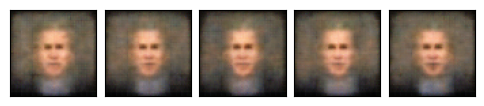

/tmp/ipykernel_1886479/3902647951.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_location=device)


*** Images Generated from best model:


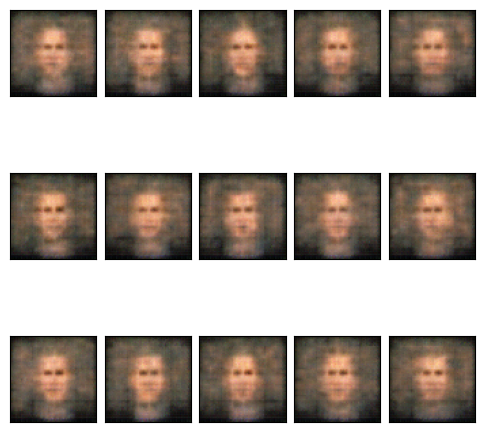

In [16]:
import IPython.display

def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        samples = vae.sample(n=5)
        fig, _ = plot.tensors_as_images(samples, figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=200, early_stopping=20, print_every=10,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)
    
# Plot images from best model
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=device)
vae_dp.load_state_dict(saved_state['model_state'])
print('*** Images Generated from best model:')
fig, _ = plot.tensors_as_images(vae_dp.module.sample(n=15), nrows=3, figsize=(6,6))

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [17]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

What does the $\sigma^2$ hyperparameter (`x_sigma2` in the code) do? Explain the effect of low and high values.

In [18]:
display_answer(hw3.answers.part2_q1)


**Your answer:**

The hyperparameter $\sigma^2$ represents the assumed variance of the data likelihood $p(\mathbf{x}|\mathbf{z}) \sim \mathcal{N}(\Psi(\mathbf{z}), \sigma^2 \mathbf{I})$. In the loss function, it acts as a weighting coefficient that controls the trade-off between the reconstruction loss and the KL-divergence regularization.

1.  **Low $\sigma^2$:**
    Effect: The reconstruction error term is scaled up (large weight). The model prioritizes minimizing pixel-wise differences between the input and output.
    Result: The model produces sharp, high-quality reconstructions. However, it may ignore the KL-divergence term, leading to a latent space that is not smooth or normally distributed (overfitting). This results in poor random sampling (generation) quality.

2.  **High $\sigma^2$:**
    Effect: The reconstruction error term is scaled down (small weight). The KL-divergence term becomes relatively more important.
    Result: The model prioritizes fitting the latent distribution to the prior $\mathcal{N}(0, I)$. The latent space becomes very regularized and smooth. However, the model may fail to encode enough information about the input, leading to blurry reconstructions and generic features (a phenomenon known as "posterior collapse").


### Question 2

1. Explain the purpose of both parts of the VAE loss term - reconstruction loss and KL divergence loss.
2. How is the latent-space distribution affected by the KL loss term?
3. What's the benefit of this effect?

In [19]:
display_answer(hw3.answers.part2_q2)


**Your answer:**

1.  **Purpose of the Loss Terms:**
    Reconstruction Loss: This term measures how well the decoded image matches the original input. Its purpose is to force the latent representation ($z$) to capture the meaningful "content" and information required to reproduce the data. Without this, the model would produce random noise.
    KL Divergence Loss: This term measures the difference (divergence) between the predicted latent distribution $q(\mathbf{z}|\mathbf{x})$ and a fixed standard normal prior $p(\mathbf{z}) = \mathcal{N}(0, I)$. Its purpose is to regularize the latent space structure.

2.  **Effect on Latent-Space Distribution:**
    The KL loss forces the encoder to map inputs to a compact, continuous, and overlapping region centered around the origin. It prevents the encoder from memorizing data points as isolated, far-apart "dots" (delta functions) or cheating by setting the variance to zero. Instead, it forces every input to be mapped to a probability cloud that resembles a standard Gaussian.

3.  **Benefit of this Effect:**
    This regularization is crucial for the VAE's generative capability:
    Sampling: Because we forced the training distribution to look like a standard normal distribution, we know exactly how to generate new data: simply sample $z \sim \mathcal{N}(0, I)$ and decode it.
    Smoothness (Interpolation): The compact space ensures that there are no "gaps" or "holes" in the latent space. Walking from one point to another in the latent space results in a smooth semantic transition in the image space, rather than sudden jumps or garbage outputs.


### Question 3

In the formulation of the VAE loss, why do we start by maximizing the evidence 
distribution, $p(X)$?

In [20]:
display_answer(hw3.answers.part2_q3)


**Your answer:**

We start by maximizing the evidence distribution $p(\mathbf{X})$ because Maximum Likelihood Estimation (MLE) is the fundamental objective of generative modeling.

1.  **The Goal:** Our goal is to train a model that learns the true underlying probability distribution of the data, $p_{data}(\mathbf{x})$. If our model assigns a high probability $p_\theta(\mathbf{x})$ to the real samples we observed, it means the model has successfully learned to recognize and generate data that looks like the training set.

2.  **The Problem:** Direct maximization of $p(\mathbf{x})$ is intractable. In a latent variable model, calculating the likelihood of a single image requires marginalizing over all possible latent variables $z$:
    $$p(\mathbf{x}) = \int p(\mathbf{x}|\mathbf{z})p(\mathbf{z}) d\mathbf{z}$$
    This integral is impossible to compute for complex neural networks.

3.  **The Solution (ELBO):** Since we cannot maximize $\log p(\mathbf{x})$ directly, we derive the Evidence Lower Bound (ELBO). By maximizing the ELBO, we implicitly maximize the log-likelihood of the data (or at least push its lower bound up), effectively training the model to satisfy the MLE objective.


### Question 4

In the VAE encoder, why do we model the **log** of the 
latent-space variance corresponding to an input, $\sigma^2_{\alpha}$,
instead of directly modelling this variance?

In [21]:
display_answer(hw3.answers.part2_q4)


**Your answer:**

We model the log-variance ($\log \sigma^2$) instead of the variance directly for two main reasons: numerical stability and mathematical constraints.

1.  **Range Constraint (Positivity):** Variance ($\sigma^2$) is mathematically required to be a non-negative number ($[0, \infty)$). Standard neural network layers (like Linear layers) produce outputs in the range $(-\infty, \infty)$.
    If we predicted $\sigma^2$ directly, we would need to enforce positivity using an activation function like ReLU or Softplus. ReLU could lead to "dead neurons" (variance = 0), causing infinite densities and numerical crashes.
    By predicting $x = \log \sigma^2$, we can allow the network to output any real number. We then compute $\sigma^2 = e^x$, which is guaranteed to be strictly positive.

2.  **Numerical Stability & Sensitivity:**
    It effectively allows the network to learn the scale of the variance.
    Small changes in the log-space correspond to multiplicative changes in the variance space. This makes it easier for the optimizer to fine-tune very small variances (which map to negative numbers like -5, -10) without dealing with tiny floating-point numbers directly during backpropagation.
